# Natural Language Processing

In [25]:
# Import data

import pandas as pd
from sklearn.model_selection import train_test_split

train_dir = "disasters_nlp/train.csv"
test_dir = "disasters_nlp/test.csv"

train_df = pd.read_csv(train_dir)
# Shuffle data
train_df_shuffle = train_df.sample(frac=1, random_state=42)

# Test data contains no labels
test_df = pd.read_csv(test_dir)
# Shuffle data
test_df_shuffle = test_df.sample(frac=1, random_state=42)

test_data = test_df_shuffle["text"].values

# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    train_df_shuffle["text"].to_numpy(),
    train_df_shuffle["target"].to_numpy(), 
    train_size=0.9,
    shuffle=False
)

X_train[:10], y_train[:10]

(array(['So you have a new weapon that can cause un-imaginable destruction.',
        'The f$&amp;@ing things I do for #GISHWHES Just got soaked in a deluge going for pads and tampons. Thx @mishacollins @/@',
        'DT @georgegalloway: RT @Galloway4Mayor: \x89ÛÏThe CoL police can catch a pickpocket in Liverpool Stree... http://t.co/vXIn1gOq4Q',
        'Aftershock back to school kick off was great. I want to thank everyone for making it possible. What a great night.',
        'in response to trauma Children of Addicts develop a defensive self - one that decreases vulnerability. (3',
        '@Calum5SOS you look like you got caught in a rainstorm this is amazing and disgusting at the same time',
        'my favorite lady came to our volunteer meeting\nhopefully joining her youth collision and i am excite http://t.co/Ij0wQ490cS',
        '@brianroemmele UX fail of EMV - people want to insert and remove quickly like a gas pump stripe reader. 1 person told me it crashed the POS',
       

In [36]:
# Setup token vectorisation layer

from keras.layers import TextVectorization

# Get average length in tokens of each sentence
avg_tokens = round(sum([len(sen.split()) for sen in X_train]) / len(X_train))

text2vec = TextVectorization(
    max_tokens=10000,
    output_sequence_length=avg_tokens,
    output_mode="int"
)

text2vec.adapt(X_train)

sample_sentence = "There's a flood in my street"
text2vec([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[281,   3, 214,   4,  13, 675,   0,   0,   0,   0,   0,   0,   0,
          0,   0]], dtype=int64)>

In [39]:
# Get the vocabulary
vocab = text2vec.get_vocabulary()

top_10_words = vocab[:10]
bottom_10_words = vocab[-10:]

print(top_10_words)
print(bottom_10_words)

['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is']
['papicongress', 'papi', 'paperback', 'papcrdoll', 'papa', 'pantofel', 'panties', 'panther', 'pantalonesfuego', 'panoramic']


# Setup token embedding layer

from keras.layers import Embedding

embed = Embedding(
    input_dim=10000,
    input_length=avg_tokens,
    output_dim=128
)

sample_embed = embed(text2vec([sample_sentence]))
sample_embed

In [88]:
# Create LSTM model with 64 hidden units

from keras.layers import Input, LSTM, Dense
from keras import Model

input = Input(shape=(1, ), dtype="string")
x = text2vec(input)
x = embed(x)
x = LSTM(64, activation="tanh")(x)
output = Dense(1, activation="sigmoid")(x)

model = Model(inputs=[input], outputs=[output])

model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_10 (Text  (None, 15)               0         
 Vectorization)                                                  
                                                                 
 embedding_2 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm_13 (LSTM)              (None, 64)                49408     
                                                                 
 dense_15 (Dense)            (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
________________________________________________

In [89]:
# Compile Model

from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam

model.compile(
    loss=BinaryCrossentropy(),
    optimizer=Adam(),
    metrics=["accuracy"]
)

In [90]:
# Setting up TensorBoard and model checkpoint callback
from keras.callbacks import TensorBoard, ModelCheckpoint

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = f"{dir_name}/{experiment_name}"
    tensorboard_callback = TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log file to {log_dir}")
    return tensorboard_callback

def create_modelcheckpoint_callback(dir_name, experiment_name):
    log_dir = f"{dir_name}/{experiment_name}"
    modelcheckpoint_callback = ModelCheckpoint(filepath=log_dir,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True)
    print(f"Saving model checkpoint to {log_dir}")
    return modelcheckpoint_callback

In [91]:
# Train model

dir_name = "disaster_nlp_callback"
experiment_name = "lstm"

history = model.fit(
    X_train,
    y_train,
    epochs=5,
    validation_data=(X_val, y_val),
    callbacks=[
        create_tensorboard_callback(dir_name, experiment_name),
        create_modelcheckpoint_callback(dir_name, experiment_name)
    ]
)

Saving TensorBoard log file to disaster_nlp_callback/lstm
Saving model checkpoint to disaster_nlp_callback/lstm
Epoch 1/5
215/215 [==============================] - 5s 12ms/step - loss: 0.1280 - accuracy: 0.9441 - val_loss: 0.9271 - val_accuracy: 0.7756
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0486 - accuracy: 0.9781 - val_loss: 1.4307 - val_accuracy: 0.7572
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0450 - accuracy: 0.9796 - val_loss: 1.2481 - val_accuracy: 0.7375
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0364 - accuracy: 0.9828 - val_loss: 1.3121 - val_accuracy: 0.7533
Epoch 5/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0502 - accuracy: 0.9775 - val_loss: 1.1505 - val_accuracy: 0.7507


<Axes: >

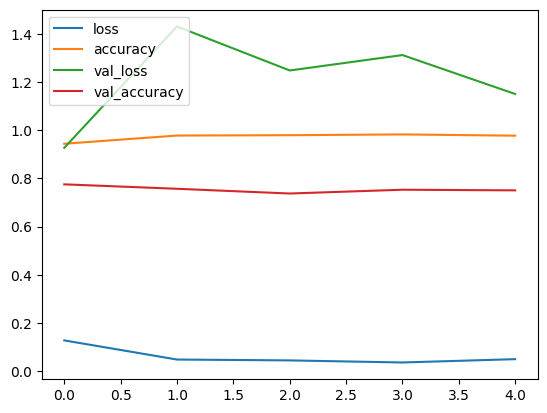

In [92]:
# Show training curves

pd.DataFrame(history.history).plot()

In [102]:
# Create biderectional LSTM model with 6 hidden units each way
# and a dropout layer with drop probability of 0.99

from keras.layers import Input, LSTM, Dense, Bidirectional, Dropout
from keras import Model

input = Input(shape=(1, ), dtype="string")
x = text2vec(input)
x = embed(x)
x = Dropout(rate=0.99)(x)
x = Bidirectional(LSTM(6, activation="tanh"))(x)
output = Dense(1, activation="sigmoid")(x)

model_2 = Model(inputs=[input], outputs=[output])

model_2.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_10 (Text  (None, 15)               0         
 Vectorization)                                                  
                                                                 
 embedding_2 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 dropout_7 (Dropout)         (None, 15, 128)           0         
                                                                 
 bidirectional_12 (Bidirecti  (None, 12)               6480      
 onal)                                                           
                                                                 
 dense_19 (Dense)            (None, 1)                 13 

In [103]:
# Compile Model

from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam

model_2.compile(
    loss=BinaryCrossentropy(),
    optimizer=Adam(1e-3),
    metrics=["accuracy"]
)

In [104]:
# Train model

dir_name = "disaster_nlp_callback"
experiment_name = "bidirectional_lstm"

history_2 = model_2.fit(
    X_train,
    y_train,
    epochs=5,
    validation_data=(X_val, y_val),
    callbacks=[
        create_tensorboard_callback(dir_name, experiment_name),
        create_modelcheckpoint_callback(dir_name, experiment_name)
    ]
)

Saving TensorBoard log file to disaster_nlp_callback/bidirectional_lstm
Saving model checkpoint to disaster_nlp_callback/bidirectional_lstm
Epoch 1/5
215/215 [==============================] - 7s 17ms/step - loss: 0.6506 - accuracy: 0.6106 - val_loss: 0.6020 - val_accuracy: 0.7113
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.5038 - accuracy: 0.7705 - val_loss: 0.5646 - val_accuracy: 0.7638
Epoch 3/5
215/215 [==============================] - 3s 13ms/step - loss: 0.4211 - accuracy: 0.8164 - val_loss: 0.5803 - val_accuracy: 0.7690
Epoch 4/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3870 - accuracy: 0.8339 - val_loss: 0.5767 - val_accuracy: 0.7848
Epoch 5/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3710 - accuracy: 0.8428 - val_loss: 0.5649 - val_accuracy: 0.7887


<Axes: >

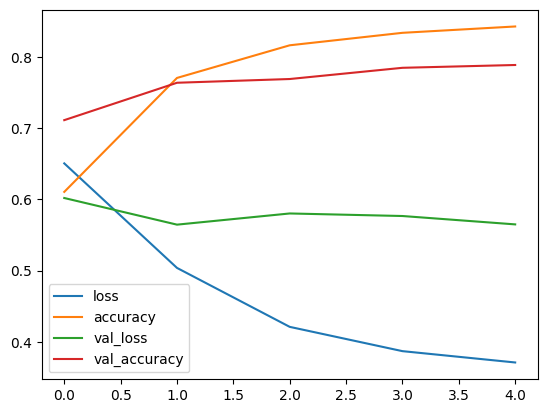

In [105]:
import pandas as pd

pd.DataFrame(history_2.history).plot()